In [716]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

# Extre libraries
from datetime import datetime

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [717]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [718]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [719]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Creating necessary columns

In [720]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Dropping null columns

In [721]:
# Validating null values
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
TotalAmount         0
dtype: int64

In [722]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price              5
Quantity       22950
TotalAmount    19498
dtype: int64

In [723]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [724]:
# # Making lists with Customers with heavily outlying behavior
# OutlierCustomersPrice = data[data['Price'] > data['Price'].quantile(0.99)]['Customer ID'].unique()
# OutlierCustomersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.99)]['Customer ID'].unique()
# OutlierCustomersTotalAmount = data[data['TotalAmount'] > data['TotalAmount'].quantile(0.99)]['Customer ID'].unique()

In [725]:
# # Combinning the lists
# outlierCustomers = np.union1d(np.union1d(OutlierCustomersPrice, OutlierCustomersQuantity),OutlierCustomersTotalAmount)

# # Excluding outliers from data
# data = data[~data['Customer ID'].isin(outlierCustomers)]

In [726]:
# Making lists with Customers with heavily outlying behavior
OutlierCustomersPrice = data[data['Price'] > data['Price'].quantile(0.9995)]['Customer ID'].unique()
OutlierCustomersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.9995)]['Customer ID'].unique()

# Combinning the lists
outlierCustomers = np.union1d(OutlierCustomersPrice, OutlierCustomersQuantity)

# Excluding outliers from data
data = data[~data['Customer ID'].isin(outlierCustomers)]

In [727]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [728]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

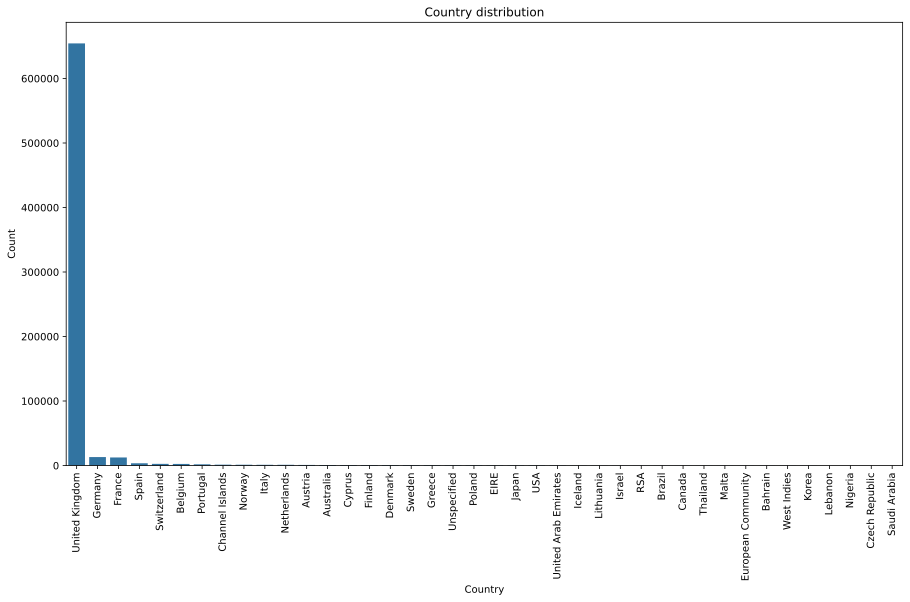

In [729]:
# Country distribution
plt.figure(figsize=(15, 8))
sns.countplot(data= data, x='Country', order=data['Country'].value_counts().index)
plt.title('Country distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation= 90)
plt.show

In [730]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [731]:
print(data['Country'].describe())

count             654357
unique                 1
top       United Kingdom
freq              654357
Name: Country, dtype: object


# Price, Quantity and Total Amount distributions

In [732]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    654357.000000
mean          9.653918
std          21.062353
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max         864.000000
Name: Quantity, dtype: float64


In [733]:
# Distribution for Price
print(data['Price'].describe())

count    654357.000000
mean          2.874230
std           3.089849
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max          85.000000
Name: Price, dtype: float64


In [734]:
# Distribution for TotalAmount
print(data['TotalAmount'].describe())

count    654357.000000
mean         16.637805
std          32.451979
min           0.000000
25%           4.160000
50%          10.200000
75%          17.700000
max        2978.400000
Name: TotalAmount, dtype: float64


# Data division between present and future

In [735]:
futureMax = data['InvoiceDate'].max()

print(futureMax)

2011-12-09 12:49:00


In [736]:
# Data delimitation (three months before)
presentvalue = pd.Timestamp('2011-09-01')

print(presentvalue)

2011-09-01 00:00:00


In [737]:
# Dividing data between present and future
futureData = data[(data['InvoiceDate'] > presentvalue) & (data['InvoiceDate'] <= presentvalue + pd.DateOffset(months=3))]

data = data[data['InvoiceDate'] <= presentvalue]

In [738]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [739]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517704 entries, 0 to 846153
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      517704 non-null  object        
 1   StockCode    517704 non-null  object        
 2   Description  517704 non-null  object        
 3   Quantity     517704 non-null  int64         
 4   InvoiceDate  517704 non-null  datetime64[ns]
 5   Price        517704 non-null  float64       
 6   Customer ID  517704 non-null  float64       
 7   Country      517704 non-null  object        
 8   TotalAmount  517704 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 39.5+ MB


In [740]:
futureData.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
846166,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,10.0
846167,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,30.0
846169,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,25.5
846170,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,30.0
846171,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,19.8


In [741]:
futureData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122624 entries, 846166 to 1041829
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      122624 non-null  object        
 1   StockCode    122624 non-null  object        
 2   Description  122624 non-null  object        
 3   Quantity     122624 non-null  int64         
 4   InvoiceDate  122624 non-null  datetime64[ns]
 5   Price        122624 non-null  float64       
 6   Customer ID  122624 non-null  float64       
 7   Country      122624 non-null  object        
 8   TotalAmount  122624 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 9.4+ MB


# Creating Customer Dataset

In [742]:
# Creating a YearMonth column in the invoice data as we wont use day and hour
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')
futureData['YearMonth'] = futureData['InvoiceDate'].dt.to_period('M')

In [743]:
data.head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount,YearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12


In [744]:
# Client by month data
monthlyData = data.groupby(['Customer ID', 'YearMonth']).agg(
    monthlySpend = ('TotalAmount', 'sum'),

    invoiceQuantity = ('Invoice', 'nunique'),

    totalQuantity = ('Quantity', 'sum')
    
).reset_index()

monthlyData.head(5)

,Customer ID,YearMonth,monthlySpend,invoiceQuantity,totalQuantity
0,12608.0,2010-10,415.79,1,323
1,12746.0,2010-06,254.55,1,97
2,12747.0,2009-12,1032.00,3,204
3,12747.0,2010-02,260.00,2,102
4,12747.0,2010-03,210.89,1,70


In [745]:
monthlyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17423 entries, 0 to 17422
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   Customer ID      17423 non-null  float64  
 1   YearMonth        17423 non-null  period[M]
 2   monthlySpend     17423 non-null  float64  
 3   invoiceQuantity  17423 non-null  int64    
 4   totalQuantity    17423 non-null  int64    
dtypes: float64(2), int64(2), period[M](1)
memory usage: 680.7 KB


In [746]:
# Definning time period (6 months)
startMonth = (presentvalue - pd.DateOffset(months = 18)).to_period('M')
endMonth = (presentvalue - pd.DateOffset(months = 1)).to_period('M')

allMonths = pd.period_range(start=startMonth, end=endMonth, freq='M')

In [747]:
# Indexing by client

# Unique clients
customers = monthlyData['Customer ID'].unique()

# Index client-month
fullIndex = pd.MultiIndex.from_product([customers, allMonths], names=['Customer ID', 'YearMonth'])

# Reindex and filling out missing months with 0
monthlyDataFull = (monthlyData.set_index(['Customer ID', 'YearMonth']).reindex(fullIndex, fill_value=0).reset_index())

In [748]:
# Making sure monthlyData fits the time window
monthlyDataFull = monthlyDataFull[(monthlyDataFull['YearMonth'] >= startMonth) & (monthlyDataFull['YearMonth'] <= endMonth)]

monthlyDataFull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   Customer ID      82332 non-null  float64  
 1   YearMonth        82332 non-null  period[M]
 2   monthlySpend     82332 non-null  float64  
 3   invoiceQuantity  82332 non-null  int64    
 4   totalQuantity    82332 non-null  int64    
dtypes: float64(2), int64(2), period[M](1)
memory usage: 3.1 MB


In [749]:
monthlyDataFull.head(5)

,Customer ID,YearMonth,monthlySpend,invoiceQuantity,totalQuantity
0,12608.0,2010-03,0.0,0,0
1,12608.0,2010-04,0.0,0,0
2,12608.0,2010-05,0.0,0,0
3,12608.0,2010-06,0.0,0,0
4,12608.0,2010-07,0.0,0,0


In [750]:
# y Creation from futureData (total spending in the next 3 months)

# Target
futureCLV = futureData.groupby('Customer ID')['TotalAmount'].sum().rename('FutureCLV')

futureCLV.head(5)

Customer ID
12747.0    988.11
12749.0    572.59
12820.0    561.53
12822.0    948.88
12823.0    535.50
Name: FutureCLV, dtype: float64

<Axes: xlabel='FutureCLV', ylabel='Percent'>

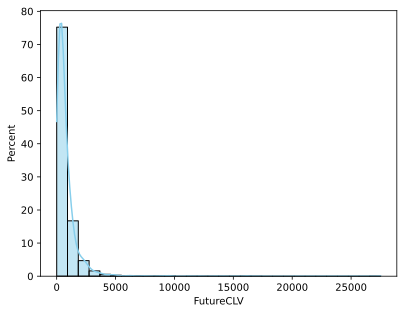

In [751]:
sns.histplot(futureCLV,bins=30, kde=True, color="skyblue", stat="percent")

In [752]:
# Now we have to align the clients in the monthlyDataFull with the clients in futureCLV

# Clients in monthlyDataFull
seqCustomers = monthlyDataFull['Customer ID'].unique()

# Indexing FutureCLV again with these clients
futureCLV = futureCLV.reindex(seqCustomers).fillna(0)

futureCLV.describe()

count     4574.000000
mean       355.097285
std       1003.274425
min          0.000000
25%          0.000000
50%          0.000000
75%        381.810000
max      27507.590000
Name: FutureCLV, dtype: float64

In [753]:
# Validations
print('Sequential Clients:', len(seqCustomers))
print('Targets (y):', futureCLV.shape[0])

# Validate that there's no nans
print('NaN in target:', futureCLV.isna().sum())

Sequential Clients: 4574
Targets (y): 4574
NaN in target: 0


# Constructing the sequential tensor (X)

In [754]:
seqFeatureCols = ['monthlySpend', 'invoiceQuantity', 'totalQuantity']

# Sorting the time series in a List
timeOrder = sorted(monthlyDataFull['YearMonth'].unique())

# This should print the 6 months in cronological order
print(timeOrder)

[Period('2010-03', 'M'), Period('2010-04', 'M'), Period('2010-05', 'M'), Period('2010-06', 'M'), Period('2010-07', 'M'), Period('2010-08', 'M'), Period('2010-09', 'M'), Period('2010-10', 'M'), Period('2010-11', 'M'), Period('2010-12', 'M'), Period('2011-01', 'M'), Period('2011-02', 'M'), Period('2011-03', 'M'), Period('2011-04', 'M'), Period('2011-05', 'M'), Period('2011-06', 'M'), Period('2011-07', 'M'), Period('2011-08', 'M')]


In [755]:
# Data we'll use to create the X tensor (Input)

# Unique customers
customers = monthlyDataFull['Customer ID'].unique()

# Number of customers
nClients = len(customers)

# Number of timesteps (months)
nTimesteps = len(timeOrder)

# Number of Features (inputs)
nFeatures = len(seqFeatureCols)

print('Clients:', nClients)
print('Timesteps:', nTimesteps)
print('Features:', nFeatures)

Clients: 4574
Timesteps: 18
Features: 3


In [756]:
# We have to make sure the order is correct, missing months = 0 and the shape of X is correct

# Tensor Init
X_seq = np.zeros((nClients, nTimesteps, nFeatures), dtype=np.float32)

# Iteration through the Clients
for i, customerId in enumerate(customers):

    # Client data
    customerData = monthlyDataFull[
        monthlyDataFull['Customer ID'] == customerId
    ].set_index('YearMonth')

    # Checking cronological order
    customerData = customerData.loc[timeOrder]

    # Feature extraction
    X_seq[i] = customerData[seqFeatureCols].values

In [757]:
# Target aligned with input X
y = futureCLV.loc[customers].values.astype(np.float32)

# Validations
print('X_seq shape:', X_seq.shape)
print('y shape:', y.shape)

X_seq shape: (4574, 18, 3)
y shape: (4574,)


In [758]:
# Extra validations 
print('NaNs in X (input sequences): ',np.isnan(X_seq).sum())
print('NaNs in y (Target): ',np.isnan(y).sum())

# Checking a random client data
randID = np.random.randint(0, nClients)
print('Client:', customers[randID])
print('Sequence:')
print(X_seq[randID])
print('Target:', y[randID])

NaNs in X (input sequences):  0
NaNs in y (Target):  0
Client: 17674.0
Sequence:
[[  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [601.32   1.   698.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]
 [  0.     0.     0.  ]]
Target: 250.38


# Data Normalization and splitting

In [759]:
# Clients index
indexes = np.arange(len(X_seq))

# 70 / 15 / 15 split
idx_train, idx_temp = train_test_split( indexes, test_size=0.21, random_state=42)

idx_val, idx_test = train_test_split(idx_temp, test_size=0.001, random_state=42)

# Data split
X_train = X_seq[idx_train]
X_val   = X_seq[idx_val]
X_test  = X_seq[idx_test]

y_train = y[idx_train]
y_val   = y[idx_val]
y_test  = y[idx_test]

print(X_train.shape, X_val.shape, X_test.shape)

(3613, 18, 3) (960, 18, 3) (1, 18, 3)


In [760]:
# log1p
X_train_log = np.log1p(X_train)
X_val_log   = np.log1p(X_val)
X_test_log  = np.log1p(X_test)

In [761]:
print(X_train_log.shape) # Clients, Months, Features

(3613, 18, 3)


In [762]:
# Robust Scaler

# Initialize scaler
scaler = RobustScaler()

# flattening only the train data
N, T, F = X_train_log.shape # N: Clients, T: Months, F: Features
X_train_flat = X_train_log.reshape(N * T, F) # we are eliminating the months value by unifying the months of the sequence by the clients

# Fit only for train data
scaler.fit(X_train_flat)

RobustScaler()

In [763]:
# Function to scale the data without breaking its form
def scaleSequenceData(X, scaler):
    n, t, f = X.shape
    X_flat = X.reshape(n * t, f)
    X_scaled = scaler.transform(X_flat)
    return X_scaled.reshape(n, t, f)

# applying scaler
X_train_scaled = scaleSequenceData(X_train_log, scaler)
X_val_scaled = scaleSequenceData(X_val_log, scaler)
X_test_scaled = scaleSequenceData(X_test_log, scaler)

In [764]:
# Some important checks
print('Train mean:', X_train_scaled.mean(axis=(0,1)))
print('Train std:',  X_train_scaled.std(axis=(0,1)))

print('NaNs train:', np.isnan(X_train_scaled).sum())
print('NaNs val:',   np.isnan(X_val_scaled).sum())
print('NaNs test:',  np.isnan(X_test_scaled).sum())

Train mean: [1.0888276  0.15243758 0.9656758 ]
Train std: [2.3009818  0.33646008 2.0626516 ]
NaNs train: 0
NaNs val: 0
NaNs test: 0


# Converting data to Pytorch tensors and creating Data loaders

In [765]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [766]:
batchSize = 32

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batchSize, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batchSize, shuffle=False)

In [767]:
# Validations
X_batch, y_batch = next(iter(train_loader))
print(X_batch.shape)
print(y_batch.shape)

torch.Size([32, 18, 3])
torch.Size([32, 1])


# GRU Model construction and INIT

In [768]:
# PRUEBAAA
class ImprovedGRUModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers=2, dropout=0.3):
        super().__init__()
        
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        
        # GRU con dropout
        self.gru = nn.GRU(
            input_size=inputSize,
            hidden_size=hiddenSize,
            num_layers=numLayers,  # 2-3 capas es suficiente
            batch_first=True,
            dropout=dropout if numLayers > 1 else 0
        )
        
        # Batch normalization
        self.bn = nn.BatchNorm1d(hiddenSize)
        
        # Fully connected layers con dropout
        self.fc1 = nn.Linear(hiddenSize, hiddenSize // 2)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hiddenSize // 2, hiddenSize // 4)
        self.dropout2 = nn.Dropout(dropout)
        
        # Output layer
        self.output = nn.Linear(hiddenSize // 4, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # GRU forward
        gruOut, h_n = self.gru(x)
        
        # Tomar el último hidden state de la última capa
        lastHidden = h_n[-1]  # Shape: (batch_size, hidden_size)
        
        # Batch normalization
        lastHidden = self.bn(lastHidden)
        
        # Fully connected layers
        x = self.relu(self.fc1(lastHidden))
        x = self.dropout1(x)
        
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # Output
        return self.output(x)

In [769]:
# PRUEBAA

# Modelo
inputSize = X_train_t.shape[2]   # 3 features
hiddenSize = 16  # Aumentado significativamente
numLayers = 1     # Reducido de 5 a 3
dropout = 0.3

model = ImprovedGRUModel(inputSize, hiddenSize, numLayers, dropout)

# Loss function
lossfun = nn.HuberLoss()

# Optimizer con learning rate MÁS BAJO
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.001,  # Reducido de 0.01 a 0.001
    weight_decay=0.01  # Aumentada la regularización
)

# Scheduler más agresivo
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=15,  # Más paciencia
    min_lr=1e-6
)

In [770]:
# Test
X_batch, y_batch = next(iter(train_loader))
y_hat = model(X_batch)

print(X_batch.shape)
print(y_hat.shape)

torch.Size([32, 18, 3])
torch.Size([32, 1])


In [771]:
def evaluateModel(model, loader):
    model.eval()

    preds = []
    trues = []

    with torch.no_grad():
        for X, y in loader:
            yhat = model(X)
            preds.append(yhat.cpu().numpy())
            trues.append(y.cpu().numpy())

    preds = np.vstack(preds).ravel()
    trues = np.vstack(trues).ravel()

    mae  = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2   = r2_score(trues, preds)

    return mae, rmse, r2

# Trainning!

In [772]:
# PRUEBA

numepochs = 250

def trainTheModel():
    trainLosses = []
    valLosses = []
    valMAEs = []
    valRMSEs = []
    valR2s = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 30
    
    for epoch in range(numepochs):
        # ===== TRAINING =====
        model.train()
        batchLoss = []
        
        for X, y in train_loader:
            optimizer.zero_grad()
            
            # Forward
            yhat = model(X)
            loss = lossfun(yhat, y)
            
            # Backprop
            loss.backward()
            
            # Gradient clipping (import for RNNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            batchLoss.append(loss.item())
        
        trainLoss = np.mean(batchLoss)
        trainLosses.append(trainLoss)
        
        # ===== VALIDATION =====
        model.eval()
        with torch.no_grad():
            valBatchLoss = []
            preds = []
            trues = []
            
            for Xv, yv in val_loader:
                yhatv = model(Xv)
                valBatchLoss.append(lossfun(yhatv, yv).item())
                
                preds.append(yhatv.cpu().numpy())
                trues.append(yv.cpu().numpy())
        
        valLoss = np.mean(valBatchLoss)
        valLosses.append(valLoss)

        preds = np.concatenate(preds, axis=0).flatten()
        trues = np.concatenate(trues, axis=0).flatten()
        
        # Métricas en escala real (£)
        mae = mean_absolute_error(trues, preds)
        rmse = np.sqrt(mean_squared_error(trues, preds))
        r2 = r2_score(trues, preds)
        
        valMAEs.append(mae)
        valRMSEs.append(rmse)
        valR2s.append(r2)
        
        # Scheduler
        scheduler.step(valLoss)
        
        # Progress (cada 10 epochs)
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch:03d} | "
                f"Train: {trainLoss:.4f} | "
                f"Val: {valLoss:.4f} | "
                f"MAE: £{mae:.2f} | "
                f"RMSE: £{rmse:.2f} | "
                f"R²: {r2:.3f} | "
                f"LR: {optimizer.param_groups[0]['lr']:.6f}"
            )
    
    return trainLosses, valLosses, valMAEs, valRMSEs, valR2s

In [773]:
trainLosses, valLosses, valMAEs, valRMSEs, valR2s = trainTheModel()

Epoch 000 | Train: 354.8245 | Val: 354.9768 | MAE: £355.35 | RMSE: £1083.84 | R²: -0.118 | LR: 0.001000
Epoch 010 | Train: 305.3011 | Val: 296.4135 | MAE: £296.83 | RMSE: £951.73 | R²: 0.138 | LR: 0.001000
Epoch 020 | Train: 301.8832 | Val: 284.2558 | MAE: £284.66 | RMSE: £901.62 | R²: 0.226 | LR: 0.001000
Epoch 030 | Train: 291.2800 | Val: 278.2594 | MAE: £278.62 | RMSE: £868.39 | R²: 0.282 | LR: 0.001000
Epoch 040 | Train: 295.0756 | Val: 290.2452 | MAE: £290.62 | RMSE: £884.34 | R²: 0.255 | LR: 0.001000
Epoch 050 | Train: 289.6898 | Val: 264.2229 | MAE: £264.61 | RMSE: £793.39 | R²: 0.401 | LR: 0.001000
Epoch 060 | Train: 288.4808 | Val: 266.1660 | MAE: £266.49 | RMSE: £766.47 | R²: 0.441 | LR: 0.001000
Epoch 070 | Train: 290.4948 | Val: 263.1635 | MAE: £263.49 | RMSE: £693.72 | R²: 0.542 | LR: 0.001000
Epoch 080 | Train: 285.3505 | Val: 267.9690 | MAE: £268.30 | RMSE: £725.51 | R²: 0.499 | LR: 0.000500
Epoch 090 | Train: 276.4798 | Val: 263.1113 | MAE: £263.45 | RMSE: £718.16 | R²: